### **Installing Libraries**

In [1]:
!pip install thop

### **Import Libraries**

In [2]:
from math import ceil
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
import os

import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot
from collections import defaultdict

import numpy as np
from scipy.signal import savgol_filter
import time
from torchvision import models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
from PIL import Image
import numpy as np
from sklearn.manifold import TSNE
import pickle
from thop import profile


import json
from PIL import Image as PilImage


### **Set GPU & define labels of dataset**

In [65]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
labels_map = {
      0: "A",
      1: "B",
      2: "C",
      3: "D",
      4: "E",
      5: "F",
      6: "G",
      7: "H",
      8: "I",
      9: "J",
      10: "K",
      11: "L",
      12: "M",
      13: "N",
      14: "Nothing",
      15: "O",
      16: "P",
      17: "Q",
      18: "R",
      19: "S",
      20: "Space",
      21: "T",
      22: "U",
      23: "V",
      24: "W",
      25: "X",
      26: "Y",
      27: "Z",
      


}
print(len(labels_map))

28


### **Print device used**

In [4]:
print(device)

cuda


# Trim Dataset 

In [28]:
import imageio as iio
import glob
import os
import torch



path="C:/Users/home/achabbra/Projects/COMP-6721-SUMMER-PROJECT/archive/ASL_Dataset/Train"
new_path="C:/Users/home/achabbra/Projects/COMP-6721-SUMMER-PROJECT/ASL_FINAL"

subDirectories = os.listdir(path) 

#Image Dataset holder
images = []
print(subDirectories)

#os.mkdir(new_path)
#for folder in subDirectories:
    #images = [iio.imread(file) for file in glob.glob(path+"/"+folder+"/*.jpg")] 
    #os.mkdir(new_path+"/"+folder)
    #print(images)
    #for count,image in enumerate(images[:1000]):
    #    iio.imwrite(new_path+"/"+folder+"/"+str(count)+".jpg", image)    

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'Nothing', 'O', 'P', 'Q', 'R', 'S', 'Space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


C:\Users\achabbra\AppData\Local\Temp\ipykernel_15504\2232506574.py:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [iio.imread(file) for file in glob.glob(path+"/"+folder+"/*.jpg")]


### **Display Dataset Images**

In [29]:
def displayImages(t_dataset,imageFlag):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    if imageFlag==0:
      figure.suptitle("Images before preprocessing")
    else:
     figure.suptitle("Images after preprocessing")   
    for i in range(1, cols * rows + 1):
      sample_idx = torch.randint(len(t_dataset), size=(1,)).item()
      img, label = t_dataset[sample_idx]
      img=np.array(img).transpose((1,2,0))
      figure.add_subplot(rows, cols, i)
      plt.title(labels_map[label])
      plt.axis("off")
      plt.imshow(img.squeeze())
    print("\n\n\n################################################\n\n\n")
    plt.show()

### **Load Data**

In [30]:
def data_loader(data_dir_input,batch_sizeGiven,input_size,flag=0,test_split=0.1,val_split=0.1):
# Define dataset directory and transforms
  data_dir = data_dir_input #
  
  data_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.554, 0.450, 0.343],[0.231, 0.241, 0.241]),
    transforms.RandomErasing()
  ])


  if flag==1:
    test_temp_dataset = datasets.ImageFolder(data_dir,transform=transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),   
  ]))
    displayImages(test_temp_dataset,0)
    test_temp_dataset = datasets.ImageFolder(data_dir,transform=data_transform)
    displayImages(test_temp_dataset,1)

    data = datasets.ImageFolder(root=data_dir, transform=data_transform)
    # Define train, validation, and test dataset
    dataset_size = len(data)
    test_size = int(test_split * dataset_size)
    val_size = int(val_split * dataset_size)
    train_size = dataset_size - (test_size + val_size)
    train_dataset, test_dataset, val_dataset = td.random_split(data,[train_size, test_size, val_size])  
    print("Train Datset Size After Split",len(train_dataset))
    print("Test Datset Size After Split",len(test_dataset))
    print("Validation Datset Size After Split",len(val_dataset))


    # Create a dictionary to store the number of images per class
    num_images_per_class = defaultdict(int)

    # Iterate over the training dataset and count the number of images in each class
    for image, label in train_dataset:
        num_images_per_class[label] += 1

    # Print the number of images per class
    for label, num_images in num_images_per_class.items():
        print(f"Class {label}: {num_images} images")
  

    # Define the number of classes and generate a list of colors
    num_classes = len(num_images_per_class)
    colors = plt.cm.Set1(np.linspace(0, 1, num_classes))

    # Plot the number of images per class as a bar plot
    #plt.bar(num_images_per_class.keys(), num_images_per_class.values(), color=colors)
    plt.pie(num_images_per_class.values(), labels=num_images_per_class.keys(), colors=colors, autopct='%1.1f%%')
    # Add axis labels and title
    plt.xlabel("Class")
    plt.ylabel("Number of images")
    plt.title("Number of images per class in the training dataset")

    # Create a legend
    labels = [f"Class {label}" for label in num_images_per_class.keys()]
    plt.legend([plt.bar(0, 0, color=colors[i])[0] for i in range(len(num_images_per_class))], labels)
    plt.rcParams["figure.figsize"] = (20,15)
    # Show the plot
    plt.show()
    
    return  

  data = datasets.ImageFolder(root=data_dir, transform=data_transform)
  # Define train, validation, and test dataset
  dataset_size = len(data)
  test_size = int(test_split * dataset_size)
  val_size = int(val_split * dataset_size)
  train_size = dataset_size - (test_size + val_size)
  train_dataset, test_dataset, val_dataset = td.random_split(data,[train_size, test_size, val_size])  
 
  train_loader = DataLoader(train_dataset, batch_size=batch_sizeGiven, shuffle=True, drop_last=False, num_workers=0,pin_memory=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_sizeGiven, shuffle=True, drop_last=False, num_workers=0,pin_memory=True) #shuffle 
  val_loader = DataLoader(val_dataset, batch_size=batch_sizeGiven, shuffle=True, drop_last=False, num_workers=0,pin_memory=True) # shuffle working


  return train_loader,test_loader,val_loader
 

### **Dataset images before and after Preprocessing**




################################################





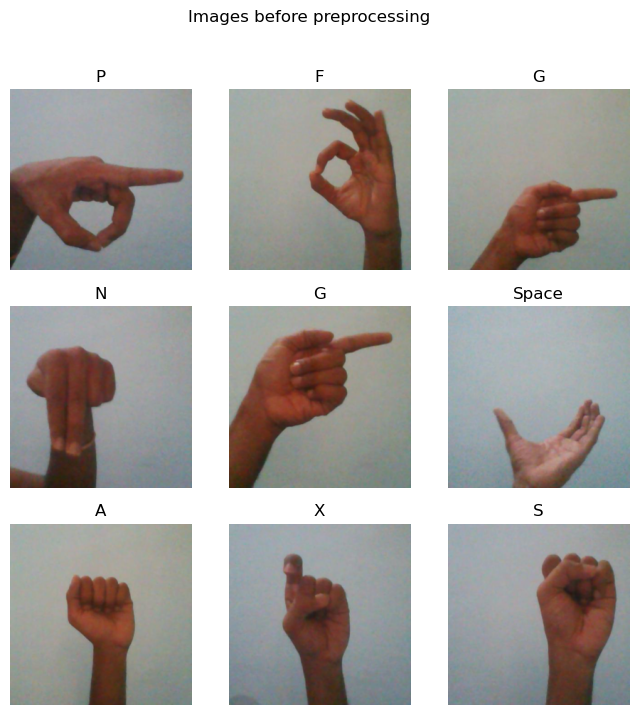

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).





################################################





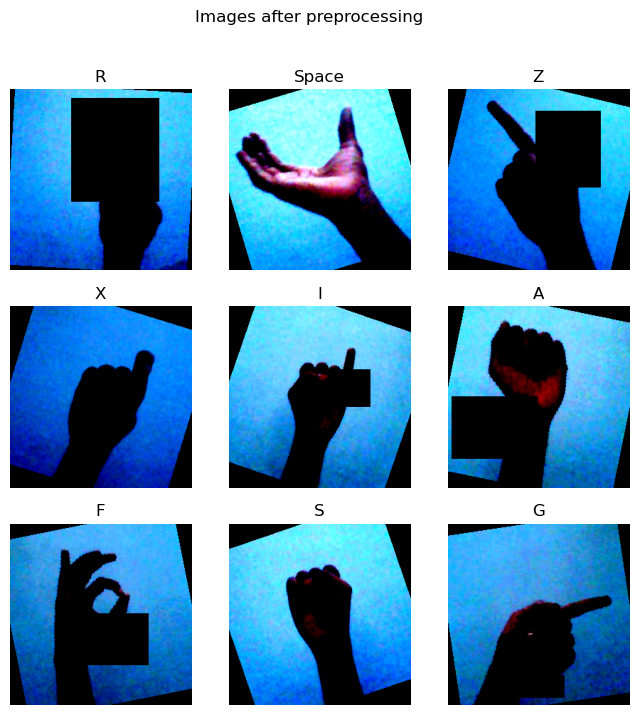

Train Datset Size After Split 22400
Test Datset Size After Split 2800
Validation Datset Size After Split 2800
Class 6: 813 images
Class 2: 802 images
Class 26: 816 images
Class 0: 793 images
Class 4: 820 images
Class 15: 798 images
Class 21: 806 images
Class 12: 814 images
Class 5: 793 images
Class 20: 828 images
Class 10: 815 images
Class 25: 797 images
Class 7: 792 images
Class 17: 795 images
Class 19: 787 images
Class 9: 787 images
Class 1: 777 images
Class 3: 784 images
Class 14: 790 images
Class 27: 815 images
Class 16: 800 images
Class 22: 808 images
Class 24: 802 images
Class 23: 795 images
Class 8: 779 images
Class 11: 794 images
Class 13: 784 images
Class 18: 816 images


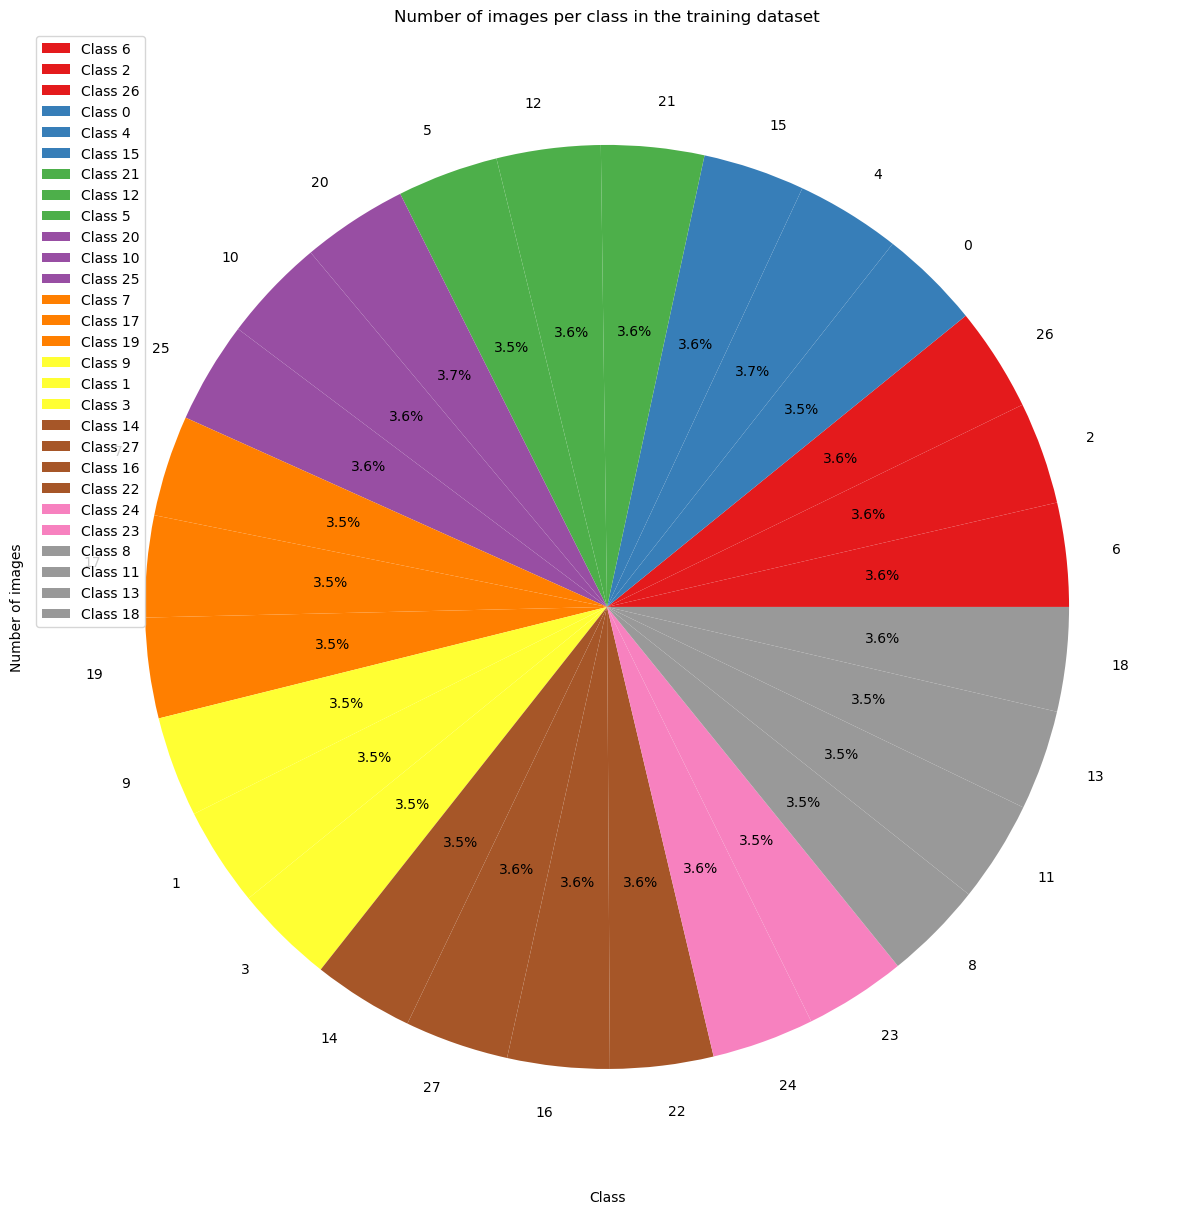

In [78]:
path="C:/Users/home/achabbra/Projects/COMP-6721-SUMMER-PROJECT/ASL_FINAL"
saveFilePath="C:/Users/achabbra/Documents/hyperparameters.pkl"
saveModelPath="C:/Users/achabbra/Documents"
batch_size=32
inputDimension=(256,256)
data_loader(path,batch_size,inputDimension,flag=1)

### **Training Loop**

In [33]:
def train(num_epochsGiven, model, train_loader, criterion, optimizer,val_loader):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print("Device: {}".format(device))
  model.to(device)
  Accuracy=[]
  validAccuracy=[]
  stepAccuracyTotal=[]
  stepAccuracyValidationTotal=[]
  stepLossTotal=[]
  Loss = []
  num_epochs = num_epochsGiven
  total_steps = len(train_loader)
  t1 = time.time()
  total,correct,loss=0,0,0
  for epoch in range(num_epochs):
      stepAcc=[]
      stepLoss=[]    
      for i, data in enumerate(train_loader):
          images, labels = data[0].to(device), data[1].to(device)
          # Forward pass
          outputs = model(images)
          loss = criterion(outputs, labels)
          # Backprop and optimisation
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          # Train accuracy
          total = labels.size(0)
          _,predicted = torch.max(outputs.data, 1)
          correct = (predicted == labels).sum().item()
          stepAcc.append((correct / total) * 100)
          stepLoss.append(loss.item())
          if (i + 1) % 30 == 0:
              stepAccuracyTotal.append((correct / total) * 100)
              stepLossTotal.append(loss.item())
              correct_v = 0
              total_v = 0
              for dataVal in val_loader:
                  images_v, labels_v = dataVal[0].to(device), dataVal[1].to(device)
                  outputs = model(images_v)
                  _, predicted = torch.max(outputs.data, 1)
                  correct_v += (predicted == labels_v).sum().item()
                  total_v += labels_v.size(0) 
              stepAccuracyValidationTotal.append((correct_v / total_v) * 100)
              print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%,Validation Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(),(correct / total) * 100,(correct_v / total_v) * 100))     
      correct_v = 0
      total_v = 0
      for dataVal in val_loader:
          images_v, labels_v = dataVal[0].to(device), dataVal[1].to(device)
          outputs = model(images_v)
          _, predicted = torch.max(outputs.data, 1)
          correct_v += (predicted == labels_v).sum().item()
          total_v += labels_v.size(0)        
      Accuracy.append(sum(stepAcc)/len(stepAcc))
      validAccuracy.append((correct_v / total_v) * 100)
      Loss.append(sum(stepLoss)/len(stepLoss))
  endTime =  time.time()
  print("######## Training Finished in {} seconds ###########".format(endTime-t1))
  print("######## Training timer per epoch is {} seconds ###########".format((endTime-t1)/num_epochsGiven))
  return Loss,Accuracy,model,validAccuracy,stepAccuracyTotal,stepAccuracyValidationTotal,stepLossTotal

### **Testing**

In [34]:
def test(model, device, test_loader):
  model.eval() 
  y_truth=[]
  y_predicted=[]
  cm=[]
  G_correct=0
  G_total=0
  
  with torch.no_grad(): 
      correct = 0
      total = 0
      for data in test_loader:
          images, labels = data[0].to(device), data[1].to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          y_truth+=labels.cpu().numpy().tolist()
          y_predicted+=predicted.cpu().numpy().tolist()
      print('Test Accuracy of the model on the {} test images: {} %'.format(total, (correct / total) * 100))
      cm= confusion_matrix(y_truth,y_predicted)
      G_total=total
      G_correct=correct
  print(classification_report(y_truth,y_predicted))
  return cm,((G_correct / G_total) * 100)


### **Hyperparameter Tuning**

Learning Rate: 0.0001, Batch Size: 32 , Loss function:  Cross Entropy Loss , Optimizer:  Adam Optimizer
Device: cuda
Epoch [1/10], Step [30/700], Loss: 2.3486, Accuracy: 28.12%,Validation Accuracy: 24.71%
Epoch [1/10], Step [60/700], Loss: 1.8157, Accuracy: 43.75%,Validation Accuracy: 34.46%
Epoch [1/10], Step [90/700], Loss: 1.2524, Accuracy: 65.62%,Validation Accuracy: 46.54%
Epoch [1/10], Step [120/700], Loss: 1.3041, Accuracy: 53.12%,Validation Accuracy: 57.50%
Epoch [1/10], Step [150/700], Loss: 0.9821, Accuracy: 78.12%,Validation Accuracy: 73.57%
Epoch [1/10], Step [180/700], Loss: 0.8481, Accuracy: 75.00%,Validation Accuracy: 74.46%
Epoch [1/10], Step [210/700], Loss: 0.7967, Accuracy: 65.62%,Validation Accuracy: 80.39%
Epoch [1/10], Step [240/700], Loss: 0.5099, Accuracy: 90.62%,Validation Accuracy: 81.07%
Epoch [1/10], Step [270/700], Loss: 0.7359, Accuracy: 78.12%,Validation Accuracy: 83.29%
Epoch [1/10], Step [300/700], Loss: 0.3751, Accuracy: 93.75%,Validation Accuracy: 85.

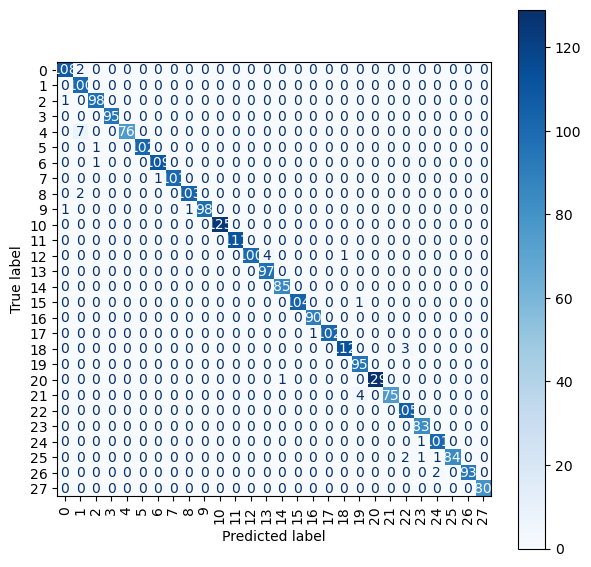

In [ ]:
res_model=[]
model_hyper_parameters = []
model_accuracy_hyper_paramaters=[]
model_accuracy_valid_hyper_paramaters=[]
model_loss_hyper_paramaters=[]

model_accuracy_hyper_paramaters_step=[]
model_accuracy_valid_hyper_paramaters_step=[]
model_loss_hyper_paramaters_step=[]
test_loss=[]

#different batch sizes
batch_sizes=[32]
#different learning rates
learning_rates=[0.0001]
#Setting the number of epochs
epochs=10


for learning_rate in learning_rates:
   for batch_size in batch_sizes:
      #Model AlexNet   
      model3 = models.resnet18(weights=None)
      model3.fc = nn.Linear(512,len(labels_map))# fine tuning the last layer
      stringCrit="Cross Entropy Loss"
      criterion=nn.CrossEntropyLoss()
      #Optimizer Function 
      stringOPTM="Adam Optimizer"
      optimizer = torch.optim.Adam(model3.parameters(), lr=learning_rate)

      model_hyper_parameters.append(["Learning Rate: "+str(learning_rate)," Batch Size: "+str(batch_size),stringCrit,stringOPTM])
      print("Learning Rate: "+str(learning_rate)+", Batch Size: "+str(batch_size),", Loss function: ",stringCrit,", Optimizer: ",stringOPTM)
      
      train_loader, test_loader, val_loader = data_loader(path,batch_size, inputDimension)
      tempLoss,tempAccuracy,tempModel,tempValidAccuracy,tempStepAccuracy,tempStepValidation,tempStepLoss = train(epochs,model3,train_loader,criterion,optimizer,val_loader)

      
      model_loss_hyper_paramaters.append(tempLoss)
      model_accuracy_hyper_paramaters.append(tempAccuracy)
      model_accuracy_valid_hyper_paramaters.append(tempValidAccuracy)

      model_accuracy_valid_hyper_paramaters_step.append(tempStepValidation)      
      model_accuracy_hyper_paramaters_step.append(tempStepAccuracy)
      model_loss_hyper_paramaters_step.append(tempStepLoss)

      cmReturned,temp_test_loss = test(model3,"cuda",test_loader)
      test_loss.append([temp_test_loss,learning_rate])
      if cmReturned is not None:
          fig, ax = plt.subplots(figsize=(7, 7))
          ConfusionMatrixDisplay(cmReturned).plot(ax=ax,cmap='Blues', xticks_rotation='vertical', values_format='d')
          plt.show()   
      res_model.append(tempModel)
  

### **Storing the loss,training accuracy,validation accuracy in a file**

In [83]:
# Saving the lists to a file
saveFilePath="C:/Users/achabbra/Documents/hyperparameters.pkl"
saveModelPath="C:/Users/achabbra/Documents"
# Loading the lists from the file
with open(saveFilePath, 'wb') as f:
    data = {
        'model_hyper_parameters': model_hyper_parameters,
        'model_accuracy_hyper_paramaters': model_accuracy_hyper_paramaters,
        'model_accuracy_valid_hyper_paramaters': model_accuracy_valid_hyper_paramaters,
        'model_loss_hyper_paramaters': model_loss_hyper_paramaters,
        'model_accuracy_hyper_paramaters_step': model_accuracy_hyper_paramaters_step,
        'model_accuracy_valid_hyper_paramaters_step': model_accuracy_valid_hyper_paramaters_step,
        'model_loss_hyper_paramaters_step': model_loss_hyper_paramaters_step,
        'test_loss': test_loss,
    }
    pickle.dump(data, f)




### **Loading the loss,training accuracy,validation accuracy in a file**

In [ ]:
# Loading the lists from the file
saveFilePath="C:/Users/achabbra/Documents/hyperparameters.pkl"
saveModelPath="C:/Users/achabbra/Documents"
with open(saveFilePath, 'rb') as f:
    data = pickle.load(f)
    model_hyper_parameters = data['model_hyper_parameters']
    model_accuracy_hyper_paramaters = data['model_accuracy_hyper_paramaters']
    model_accuracy_valid_hyper_paramaters = data['model_accuracy_valid_hyper_paramaters']
    model_loss_hyper_paramaters = data['model_loss_hyper_paramaters']
    model_accuracy_hyper_paramaters_step = data['model_accuracy_hyper_paramaters_step']
    model_accuracy_valid_hyper_paramaters_step = data['model_accuracy_valid_hyper_paramaters_step']
    model_loss_hyper_paramaters_step = data['model_loss_hyper_paramaters_step']
    test_loss=data['test_loss']

In [39]:
num_epochs = [(i+1) for i in range(epochs)]
plt.rcParams.update({'font.size': 12})

### **Accuracy Plot(without smoothening)**

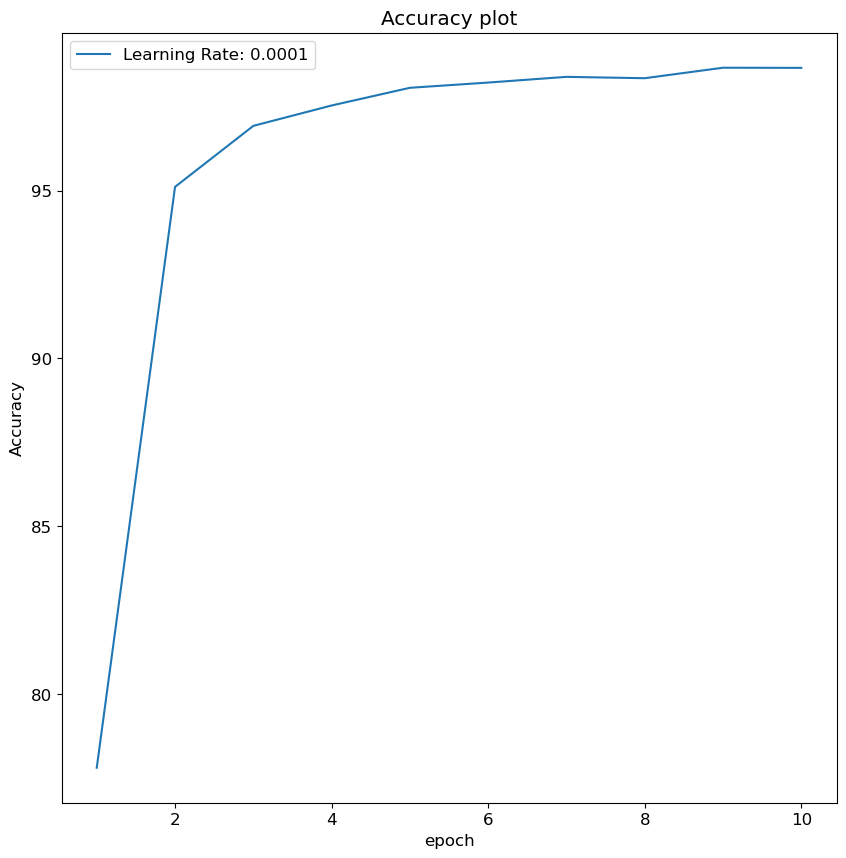

In [40]:
plt.figure(figsize=(10, 10))
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')


for i in range(len(model_hyper_parameters)):
    plt.plot(num_epochs,model_accuracy_hyper_paramaters[i],label=model_hyper_parameters[i][0])
plt.legend()

### **Accuracy Plot(with smoothening)**

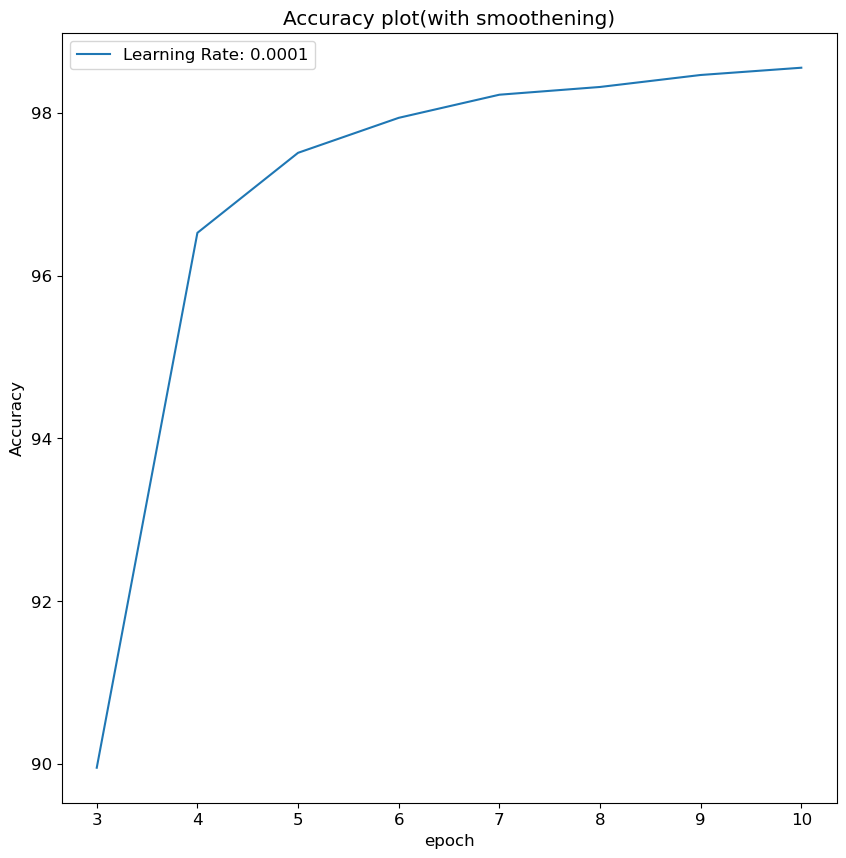

In [41]:
epochs = 10
num_epochs = [(i+1) for i in range(epochs)]
plt.figure(figsize=(10, 10))
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot(with smoothening)')

window_size = 3  # choose the window size for smoothing

for i in range(len(model_hyper_parameters)):
    accuracy = model_accuracy_hyper_paramaters[i]
    smoothed_accuracy = np.convolve(accuracy, np.ones(window_size)/window_size, mode='valid')
    plt.plot(num_epochs[-len(smoothed_accuracy):], smoothed_accuracy, label=model_hyper_parameters[i][0])
plt.legend()

### **Loss Plot(without smoothening)**

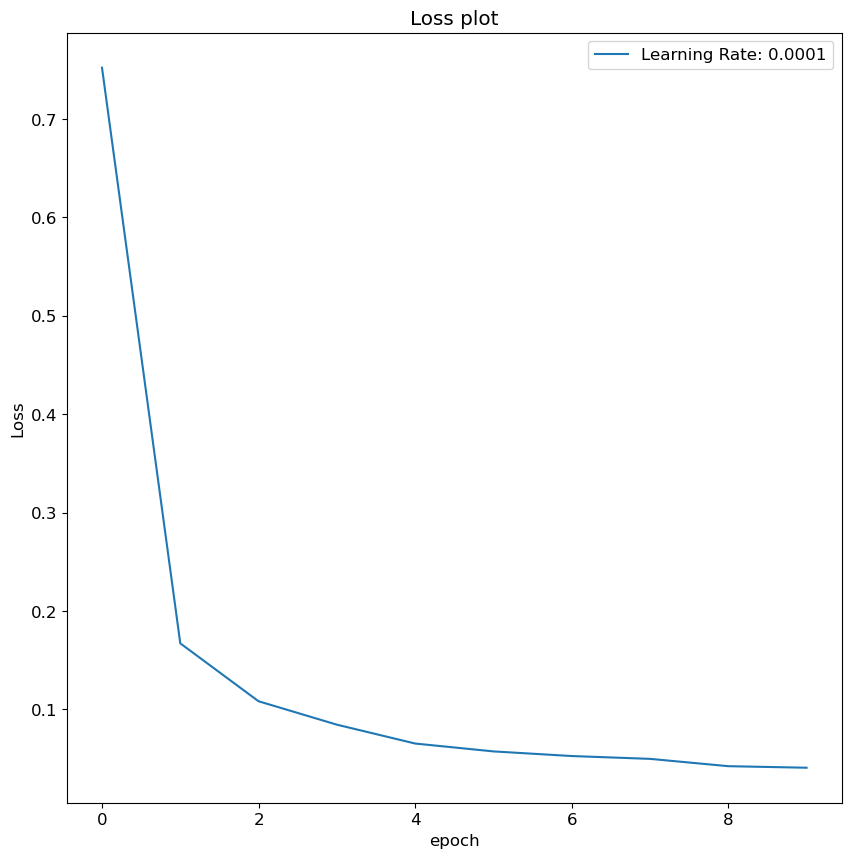

In [43]:
plt.figure(figsize=(10, 10))
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss plot')
#plt.ylim(0,3)
print()

for i in range(len(model_hyper_parameters)):
    #print(model_loss_hyper_paramaters[i])
    plt.plot(model_loss_hyper_paramaters[i],label=model_hyper_parameters[i][0])
plt.legend()

### **Loss Plot(with smoothening)**

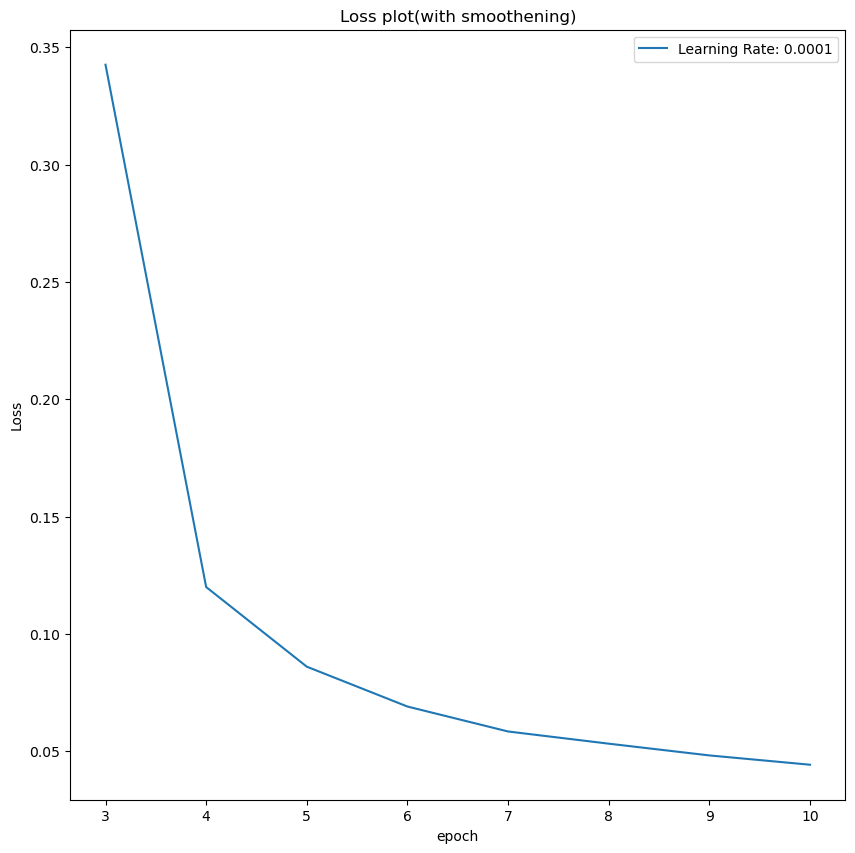

In [51]:

epochs = 10
num_epochs = [(i+1) for i in range(epochs)]
plt.figure(figsize=(10, 10))
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss plot(with smoothening)')
#plt.ylim(0,3)
window_size = 3  # choose the window size for smoothing

for i in range(len(model_hyper_parameters)):
    losses = model_loss_hyper_paramaters[i]
    smoothed_losses = np.convolve(losses, np.ones(window_size)/window_size, mode='valid')
    plt.plot(num_epochs[-len(smoothed_losses):], smoothed_losses, label=model_hyper_parameters[i][0])
    
plt.legend()

### **Loss Plot with respect to steps(without smoothening)**

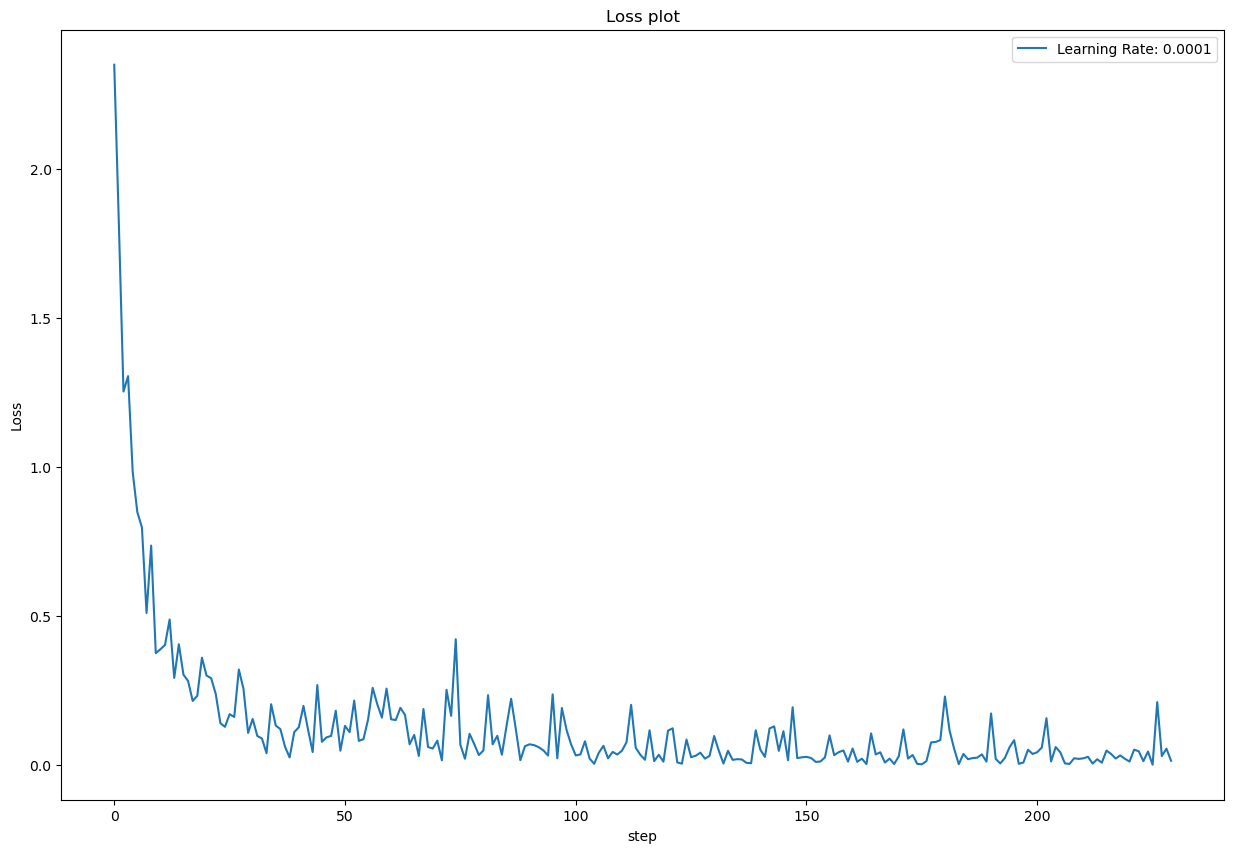

In [52]:
plt.figure(figsize=(15, 10))
plt.xlabel('step')
plt.ylabel('Loss')
plt.title('Loss plot')
#plt.ylim(0,3)

for i in range(len(model_hyper_parameters)):
    plt.plot(model_loss_hyper_paramaters_step[i],label=model_hyper_parameters[i][0])
plt.legend()

### **Loss Plot with respect to steps(with smoothening)**

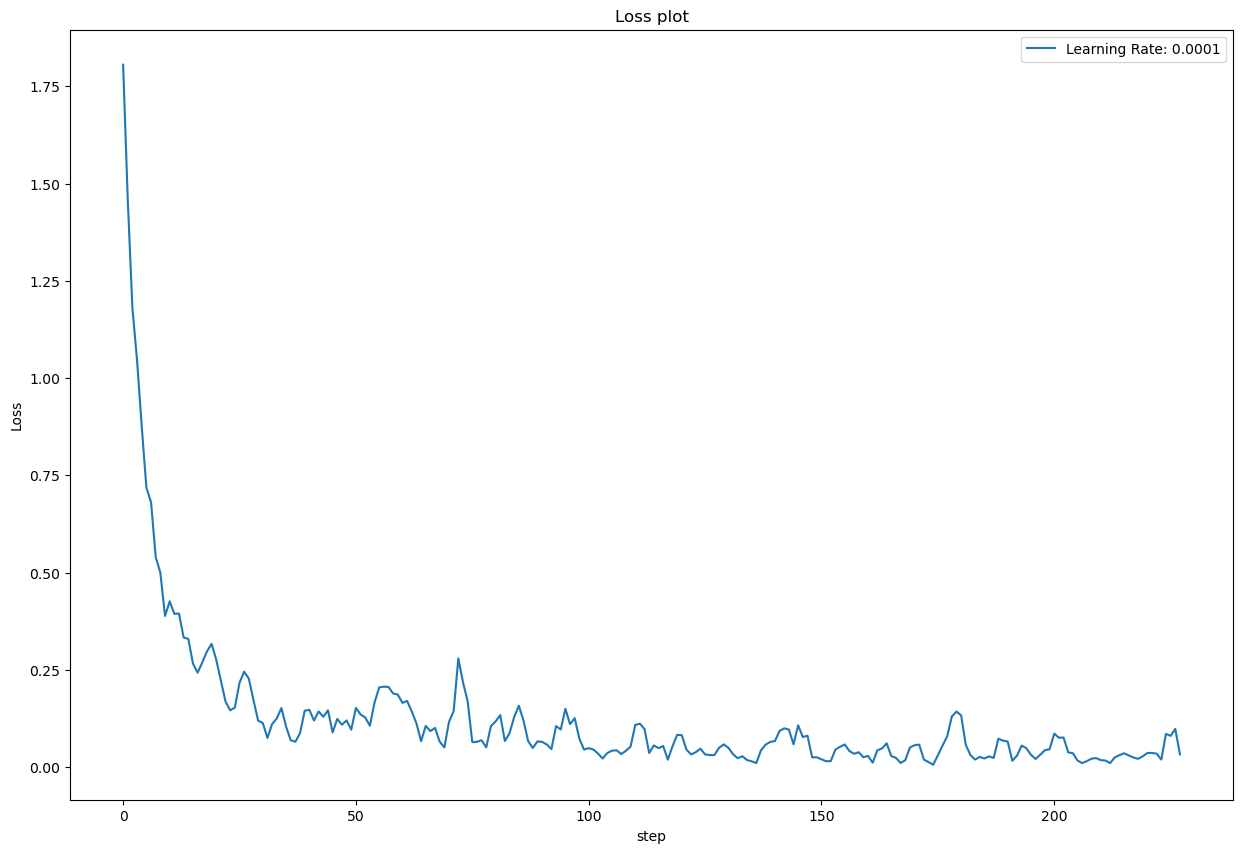

In [53]:
plt.figure(figsize=(15, 10))
plt.xlabel('step')
plt.ylabel('Loss')
plt.title('Loss plot')
#plt.ylim(0,3)
window_size = 3

for i in range(len(model_hyper_parameters)):
    # apply moving average filter to loss values
    smoothed_loss = np.convolve(model_loss_hyper_paramaters_step[i], np.ones(window_size)/window_size, mode='valid')
    plt.plot(smoothed_loss, label=model_hyper_parameters[i][0])

plt.legend()



